In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
import scipy.stats
import math

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics.cluster import completeness_score

# 1. upload data sets, and convert to pandas data frames
country_stats_data = pd.read_csv("country_happiness_report.csv")
all_int_football_results = pd.read_csv("all_int_football_results.csv")
historic_wc_top_three = pd.read_csv("historical_world_cup_top_three.csv")
fifa_players_data = pd.read_csv("fifa_players.csv")
womens_wc = pd.read_csv('FIFA Womens World Cup Results.csv')
# 2. clean data.
# replace missing values by mean of set, given attribute and data set.
# replace missing values by mode of set, given attribute and data set.
# given attrs to keep in the set, trim set.
# aggregate to provide clarity when relevant
# organize existing data into meaningful data frames.


In [2]:
# extra dataset not yet needed
# TODO: delete this if we won't use it.
# historic_wc_games_data = pd.read_csv("historical_world_cup_final_bracket_games.csv")

Functions

In [3]:
def changeCountryNameW(country):
    if country == 'CHN':
        return 'China'
    if country =='DEN':
        return 'Denmark'
    if country =='JPN':
        return 'Japan'
    if country =='GER':
        return 'Germany'
    if country =='SWE':
        return 'Sweden'
    if country =='TPE':
        return 'China'
    if country =='NOR':
        return 'Norway'
    if country =='ITA':
        return 'Italy'
    if country =='BRA':
        return 'Brazil'
    if country == 'USA':
        return 'United States'
    if country =='ENG':
        return 'United Kingdom'
    if country =='NGA':
        return 'Nigeria'
    if country =='AUS':
        return 'Australia'
    if country =='PRK':
        return 'Korea, Dem. People’s Rep.'
    if country =='CAN':
        return 'Canada'
    if country =='GHA':
        return 'Ghana'
    if country =='MEX':
        return 'Mexico'
    if country =='FRA':
        return 'France'
    if country =='KOR': 
        return 'Korea, Rep.'
    if country =='ARG':
        return 'Argentina'
    if country =='NZL':
        return 'New Zealand'
    if country =='COL':
        return 'Colombia'
    if country =='EQG':
        return 'Equatorial Guinea'
    if country =='CMR':
        return 'Cameroon'
    if country =='ESP':
        return 'Spain'
    if country =='CIV':
        return 'Cote d\'Ivoire'
    if country =='SUI':
        return 'Switzerland'
    if country =='THA':
        return 'Thailand'
    if country =='NED':
        return 'Netherlands'
    if country =='ECU':
        return 'Ecuador'
    if country =='CRC':
        return 'Costa Rica'
    if country == 'RUS':
        return 'Russian Federation'
    return country

# Data Cleaning, Massaging, and Merging

Player Data Select Attrs for Dimensions and Fill Missing Values by Mean or Mode

In [4]:
# player data. original:
fifa_players_data.head()

,id,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,...,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
0,158023,L. Messi,Lionel Andrés Messi Cuccittini,1987-06-24,31,170.18,72.1,"CF,RW,ST",Argentina,94,...,64+2,61+2,61+2,61+2,64+2,59+2,48+2,48+2,48+2,59+2
1,190460,C. Eriksen,Christian Dannemann Eriksen,1992-02-14,27,154.94,76.2,"CAM,RM,CM",Denmark,88,...,71+3,71+3,71+3,71+3,71+3,66+3,57+3,57+3,57+3,66+3
2,195864,P. Pogba,Paul Pogba,1993-03-15,25,190.50,83.9,"CM,CAM",France,88,...,76+3,77+3,77+3,77+3,76+3,74+3,72+3,72+3,72+3,74+3
3,198219,L. Insigne,Lorenzo Insigne,1991-06-04,27,162.56,59.0,"LW,ST",Italy,88,...,63+3,58+3,58+3,58+3,63+3,58+3,44+3,44+3,44+3,58+3
4,201024,K. Koulibaly,Kalidou Koulibaly,1991-06-20,27,187.96,88.9,CB,Senegal,88,...,73+3,77+3,77+3,77+3,73+3,76+3,85+3,85+3,85+3,76+3


In [5]:
# reduce dimensionality.
top_player_attrs = [
    'full_name',
    'nationality',
    'overall_rating',
    'positions',
    'value_euro',
    'wage_euro',
    'preferred_foot',
    'international_reputation(1-5)',
    'body_type',
    'national_team', # use nationality if na
]
selected_attrs_cols = [col for col in fifa_players_data.columns if col in top_player_attrs]
fifa_top_players_data = fifa_players_data[selected_attrs_cols]

In [6]:
# fill national team based on nationality if value is null.
fifa_top_players_data['national_team'] = fifa_players_data.national_team.fillna(fifa_top_players_data['nationality'])


/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
# fill numeric missing values with mean.
# fill categorical missing values with mode.
# normalize attribute values that are numeric for consistency in correlation
# sort players by overall rating.
top_player_fill_mean_attrs = [
    'overall_rating',
    'value_euro',
    'wage_euro',
    'international_reputation(1-5)',
]
top_player_fill_mode_attrs = [
    'preferred_foot',
    'body_type',
]

# data cleaning - fill by means and modes based on attr set.
fifa_top_players_data[top_player_fill_mean_attrs] = fifa_top_players_data[top_player_fill_mean_attrs].transform(lambda x: x.fillna(x.mean()))
fifa_top_players_data[top_player_fill_mode_attrs] = fifa_top_players_data[top_player_fill_mode_attrs].transform(lambda x: x.fillna(x.mode()))


/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [8]:

# normalize numeric attr values
top_player_subset_attrs = [
    'full_name',
    'nationality',
    'overall_rating',
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'freekick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots'
]
# create a subset data table for player skills
top_player_skill_attrs = [attr for attr in top_player_subset_attrs if attr is not 'full_name' and attr is not 'nationality' ]
selected_attrs_cols = [col for col in fifa_players_data.columns if col in top_player_subset_attrs]

fifa_top_players_skills_data = fifa_players_data[selected_attrs_cols]
# normalize
fifa_top_players_skills_data[top_player_skill_attrs] = fifa_top_players_skills_data[top_player_skill_attrs].apply(lambda x:(x-x.min()) / (x.max()-x.min()))


In [9]:
# sort by overall rating
fifa_top_players_skills_data.sort_values(by=['overall_rating'], inplace=True, ascending=False)

/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


World Cup Historical Performance Summary

In [10]:
# historical WC performance head.

wc_hist_perf_summary = pd.DataFrame(data=historic_wc_top_three['Country'])
historic_wc_top_three.head()

,Year,Country,Winner,Runners-Up,Third,Fourth,GoalsScored,QualifiedTeams,MatchesPlayed,Attendance
0,1930,Uruguay,Uruguay,Argentina,USA,Yugoslavia,70,13,18,590.549
1,1934,Italy,Italy,Czechoslovakia,Germany,Austria,70,16,17,363
2,1938,France,Italy,Hungary,Brazil,Sweden,84,15,18,375.7
3,1950,Brazil,Uruguay,Brazil,Sweden,Spain,88,13,22,1.045.246
4,1954,Switzerland,Germany FR,Hungary,Austria,Uruguay,140,16,26,768.607


In [11]:
# methods
# selections
# historic_wc_top_three
finishes = ['Winner', 'Runners-Up', 'Third', 'Fourth']

for finish in finishes:
    temp_sum = pd.DataFrame()
    temp_sum[finish] = historic_wc_top_three[finish].value_counts()
    temp_sum = temp_sum.rename_axis('Country')
    temp_sum['Country'] = temp_sum.index
    temp_sum.index.rename('test')
    wc_hist_perf_summary = pd.merge(wc_hist_perf_summary,temp_sum, how='left', on="Country", left_index=False, right_index=False)



/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: FutureWarning: 'Country' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
# aggregate records in terms of number of times finishing in a given place in final four
# fill na with 0
wc_hist_perf_summary[finishes] = wc_hist_perf_summary[finishes].transform(lambda x: x.fillna(0)).transform(lambda x: x.astype(int))


In [13]:
# add column for sum of total QF appearances
# rename some columns so there is clearly First, Second, Third, Fourth 

wc_hist_perf_summary['Sum QF Appearances'] = wc_hist_perf_summary.sum(axis=1)
wc_hist_perf_summary = wc_hist_perf_summary.rename(columns={'Runners-Up': 'Second', 'Winner': 'First'})
wc_hist_perf_summary.head()

,Country,First,Second,Third,Fourth,Sum QF Appearances
0,Uruguay,2,0,0,3,5
1,Italy,4,2,1,1,8
2,France,1,1,2,1,5
3,Brazil,5,2,2,2,11
4,Switzerland,0,0,0,0,0


Country's Top Finishes in Quarter Finals

In [14]:
# aggregate top finishes for each country using aggregated data on qf finishes (only including qf finishes)
fifa_wc_results = all_int_football_results.loc[all_int_football_results['tournament'] == 'FIFA World Cup']
def find_top_finish_in_qf(row):
    # print(row['Country'])
    country = row['Country']
    finishes = wc_hist_perf_summary.loc[wc_hist_perf_summary['Country'] == country]
    top_finish = 0
    first = (finishes.First).all()
    second = (finishes.Second).all()
    third = (finishes.Third).all()
    fourth = (finishes.Fourth).all()
    if (first):
        top_finish = 1
    elif (second):
        top_finish = 2
    elif (third):
        top_finish = 3
    elif (fourth):
        top_finish = 4
    return top_finish

top_finishes_in_qf = pd.DataFrame(data=wc_hist_perf_summary['Country'])
top_finishes_in_qf['top finish'] = top_finishes_in_qf.apply(lambda x: find_top_finish_in_qf(x), axis=1)
top_finishes_in_qf.head()

,Country,top finish
0,Uruguay,1
1,Italy,1
2,France,1
3,Brazil,1
4,Switzerland,0


Country Stats by Country

In [15]:
# minimize, clean, and aggregate country happiness data
# minimize number of attributes in set
# select a number of years for each country using broundaries.
# TODO: add a row for a year not present based on mean.
# find the mean for each country
# TODO: remove years column
# for data with NAN values, data was NaN for all values in country.  Update with mean from column.
selected_attrs_country = [
    'country',
    'year', 
    'Life Ladder',
    'Log GDP per capita',
    'Social support',
    'Healthy life expectancy at birth',
    'Freedom to make life choices',
    'Generosity',
    'Positive affect',
    'Negative affect',
    'Confidence in national government', 
    'Democratic Quality',
    'Most people can be trusted, Gallup',
]

attrs_for_cleaning_nans = [
    'Life Ladder',
    'Log GDP per capita',
    'Social support',
    'Healthy life expectancy at birth',
    'Freedom to make life choices',
    'Generosity',
    'Positive affect',
    'Negative affect',
    'Confidence in national government', 
    'Democratic Quality',
    'Most people can be trusted, Gallup',
]

key_country_attrs = attrs_for_cleaning_nans

# minimize data set
selected_attrs_cols = [col for col in country_stats_data.columns if col in selected_attrs_country]
country_data = country_stats_data[selected_attrs_cols]

# set date boundaries 
start_remove = 2014
end_remove = 2016
# group data by country and use mean for group override NAN with mean.
for attr in attrs_for_cleaning_nans:
    country_data[attr] = country_data.groupby('country', as_index=False)[attr].transform(lambda x: x.fillna(x.mean()))

# filter for years in boundaries
country_data = country_data.loc[(country_data.year >= start_remove) & (country_data.year <= end_remove)]
# get mean for country over years
country_data = country_data.groupby('country', as_index=False)[selected_attrs_cols].mean()
# remaining NaNs are because data was NaN for all values in country.  replace these with mean from column.
country_data = country_data.fillna(country_data.mean())
country_data.head()


/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Positive affect,Negative affect,Confidence in national government,Democratic Quality,"Most people can be trusted, Gallup"
0,Afghanistan,2015.0,3.777973,7.507917,0.537746,49.588539,0.473336,0.090321,0.550066,0.354156,0.331531,-1.895385,0.281074
1,Albania,2015.0,4.643838,9.251357,0.634452,68.531487,0.722773,-0.041561,0.682841,0.335558,0.468892,0.116744,0.126247
2,Algeria,2015.0,5.871535,9.531784,0.783170,64.624016,0.569640,-0.212148,0.647371,0.274119,0.472700,-1.085674,0.233018
3,Angola,2014.0,3.794838,8.847354,0.754615,45.092995,0.374542,-0.164495,0.578517,0.367864,0.572346,-0.705554,0.233018
4,Argentina,2015.0,6.598489,9.658498,0.909061,67.291908,0.824661,-0.131493,0.852525,0.284971,0.402231,0.166956,0.199123


Total Wins By Country in 2018 Men's World Cup Matches

Consolidate Winner Sets

In [16]:
def find_winner(row, score_a, score_b, team_a, team_b):
    if row[score_a] > row[score_b]:
        return row[team_a]
    elif row[score_a] < row[score_b]:
        return row[team_b]
    else:
        return 'tie'

# TODO: compile this into dataset in csv form https://www.wikiwand.com/en/2018_FIFA_World_Cup_statistics#/Overall_results
# add new column from function given row data
def build_winner_consolidated(dataset, determinant_function, score_a, score_b, team_a, team_b):
    dataset['winner'] = dataset.apply(lambda row: determinant_function(row, score_a, score_b, team_a, team_b), axis=1)
    dataset_winners = dataset.groupby(['winner']).winner.agg('count').to_frame('num_wins').reset_index()
    dataset_winners = pd.DataFrame(dataset_winners)
    dataset_winners = dataset_winners[dataset_winners.winner != 'tie']
    dataset_winners.sort_values(by=['num_wins'], inplace=True, ascending=False)
    return dataset_winners
    

In [17]:
# filter data for all WC games
fifa_wc_results = all_int_football_results.loc[all_int_football_results['tournament'] == 'FIFA World Cup']
# filter data for 2018 WC games
fifa_wc_results_2018 = fifa_wc_results.loc[all_int_football_results['date'].str.contains('2018')]

In [18]:
# for 2018 fifa wc results
# aggregate wins by country to total be total counts
# sort

fifa_wc_results_2018_winners = build_winner_consolidated(
    fifa_wc_results_2018, find_winner, 'home_score', 'away_score', 'home_team', 'away_team')
# fifa_wc_results_2018_winners.head()


/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Women's WC Data Transform

In [19]:
womens_wc_v_2 = womens_wc
womens_wc_v_2['Team 1'] = womens_wc.apply(lambda row: changeCountryNameW(row['Team 1']), axis=1)
womens_wc_v_2['Team 2'] = womens_wc.apply(lambda row: changeCountryNameW(row['Team 2']), axis=1)
womens_wc_v_2 = womens_wc.rename(
    columns={'Score 1': 'score_one', 'Score 2': 'score_two', 'Team 1': 'team_one', 'Team 2': 'team_two'})

In [20]:
#womens_wc.head()
womens_wc_winners = build_winner_consolidated(
    womens_wc_v_2, find_winner, 'score_one', 'score_two', 'team_one', 'team_two')
fifa_wc_womens_results_all_time_winners = womens_wc_winners

In [21]:
womens_wc_winners.head()

,winner,num_wins
22,United States,33
8,Germany,26
16,Norway,22
18,Sweden,18
1,Brazil,18


Fifa World Cup Winners as Historical Sum by Country

In [22]:
# fifa_wc_results
# minimize dataset to only FIFA World Cup matches from 2018. 
# determine winners of matches
# aggregate wins by country to total be total counts
# sort
fifa_wc_results = all_int_football_results.loc[all_int_football_results['tournament'] == 'FIFA World Cup']
fifa_wc_results_all_time = fifa_wc_results

# TODO: compile this into dataset in csv form https://www.wikiwand.com/en/2018_FIFA_World_Cup_statistics#/Overall_results
# add new column from function given row data
fifa_wc_results_all_time_winners = build_winner_consolidated(
    fifa_wc_results_all_time, find_winner, 'home_score', 'away_score', 'home_team', 'away_team')
fifa_wc_results_all_time_winners.head()

/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,winner,num_wins
6,Brazil,73
21,Germany,67
26,Italy,45
1,Argentina,43
19,France,34


# Cleaned Datasets

In [23]:
# datasets
# top players skills, in order of rank.
fifa_top_players_skills_data.head()
# world cup performance summary for each country, showing number of times they finished in the top four and sum of 
# all qf appearances, historically.
wc_hist_perf_summary.head()
# top finish for a country who has played in a WC quarter final match.
top_finishes_in_qf.head()
# country data happiness
country_data.head()
# 2018 wc number of wins for top countries (excluding 2018)
fifa_wc_results_2018_winners.head()
# total number of matches won by each countries in all world cups, historically (excluding 2018 data)
fifa_wc_results_all_time_winners.head()
# total number of matches won by each countries in all women's world cups, historically (excluding 2019 data)
fifa_wc_womens_results_all_time_winners.head()

,winner,num_wins
22,United States,33
8,Germany,26
16,Norway,22
18,Sweden,18
1,Brazil,18


# Merge Datasets for Analysis

In [24]:
# join simple soccer 2018 wc wins and country data set
merged_2018_wc_wins_and_happiness_by_country = pd.merge(left=fifa_wc_results_2018_winners,right=country_data, left_on='winner', right_on='country')
m_a_h_c_2018 = merged_2018_wc_wins_and_happiness_by_country.drop(['winner'], axis=1)
m_a_h_c_2018 = m_a_h_c_2018.rename(columns={"num_wins": "total wc wins of country"})
merged_2018_wc_wins_and_happiness_by_country = m_a_h_c_2018
m_a_h_c_2018.head()
# merged_2018_wc_wins_and_happiness_by_country = m_a_h_c_2018

,total wc wins of country,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Positive affect,Negative affect,Confidence in national government,Democratic Quality,"Most people can be trusted, Gallup"
0,6,Belgium,2015.0,6.902828,10.624256,0.919241,71.521675,0.865396,-0.006026,0.789134,0.250390,0.449104,1.075157,0.306121
1,6,France,2015.0,6.433234,10.527748,0.886049,72.462580,0.802430,-0.126228,0.789894,0.233777,0.292011,0.851397,0.198650
2,4,Uruguay,2015.0,6.453670,9.900286,0.897924,68.120193,0.902528,-0.072871,0.867820,0.278072,0.523013,0.990709,0.277648
3,4,Croatia,2014.5,5.293065,9.914950,0.707031,67.503502,0.606201,0.013581,0.602532,0.289957,0.259938,0.538784,0.206280
4,3,Sweden,2015.0,7.298938,10.718898,0.924747,71.961449,0.932794,0.172794,0.823103,0.199762,0.516122,1.371415,0.562753


In [25]:
# merge num_wins with happiness data for each row (keep rows joined on country), correlation for attr.
fifa_wc_winners_and_country_happiness = pd.merge(left=fifa_wc_results_all_time_winners,right=country_data, left_on='winner', right_on='country')
fifa_wc_winners_and_country_happiness = fifa_wc_winners_and_country_happiness.drop(['year', 'winner'], axis=1)
# fifa_wc_winners_and_country_happiness.head()

In [26]:
# merge num_wins with happiness data for each row (keep rows joined on country), correlation for attr.
womens_fifa_wc_winners_and_country_happiness = pd.merge(left=fifa_wc_womens_results_all_time_winners,right=country_data, left_on='winner', right_on='country')
womens_fifa_wc_winners_and_country_happiness = womens_fifa_wc_winners_and_country_happiness.drop(['year', 'winner'], axis=1)
# fifa_wc_winners_and_country_happiness.head()

In [27]:
# womens_fifa_wc_winners_and_country_happiness.head()

In [28]:
top_wc_finishes_and_country_happiness = pd.merge(left=top_finishes_in_qf,right=country_data, left_on='Country', right_on='country')
top_wc_finishes_and_country_happiness = top_wc_finishes_and_country_happiness.drop(['year', 'Country'], axis=1)
top_wc_finishes_and_country_happiness.head()

,top finish,country,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Positive affect,Negative affect,Confidence in national government,Democratic Quality,"Most people can be trusted, Gallup"
0,1,Uruguay,6.453670,9.900286,0.897924,68.120193,0.902528,-0.072871,0.867820,0.278072,0.523013,0.990709,0.277648
1,1,Italy,5.942931,10.422762,0.911366,72.727562,0.607346,-0.076797,0.697753,0.341467,0.269087,0.730997,0.207117
2,1,Italy,5.942931,10.422762,0.911366,72.727562,0.607346,-0.076797,0.697753,0.341467,0.269087,0.730997,0.207117
3,1,France,6.433234,10.527748,0.886049,72.462580,0.802430,-0.126228,0.789894,0.233777,0.292011,0.851397,0.198650
4,1,France,6.433234,10.527748,0.886049,72.462580,0.802430,-0.126228,0.789894,0.233777,0.292011,0.851397,0.198650


In [29]:
fifa_top_players_skills_and_country_happiness = pd.merge(left=fifa_top_players_skills_data,right=country_data, left_on='nationality', right_on='country')

f_t_p_s_c_h_a_wins = pd.merge(left=fifa_wc_results_all_time_winners,right=fifa_top_players_skills_and_country_happiness, left_on='winner', right_on='country')
f_t_p_s_c_h_a_wins = f_t_p_s_c_h_a_wins.drop(['winner'], axis=1)
fifa_top_players_skills_and_country_happiness = f_t_p_s_c_h_a_wins.rename(columns={"num_wins": "wc_wins_for_country"})
# fifa_top_players_skills_and_country_happiness.head()

In [30]:
mergable_fifa_wc_results_all_time_winners = fifa_wc_results_all_time_winners.rename(
    columns={"num_wins": "total_wc_wins_for_country"})
mergable_fifa_wc_womens_results_all_time_winners = fifa_wc_womens_results_all_time_winners.rename(
    columns={"num_wins": "total_womens_wc_wins_for_country"})



In [31]:
x = fifa_top_players_skills_and_country_happiness.groupby('country').mean()
a = pd.merge(left=x, right=fifa_wc_results_2018_winners, left_on='country', right_on='winner')
# a = pd.merge(left=a, right=mergable_fifa_wc_results_all_time_winners, left_on='winner', right_on='winner')
a = pd.merge(left=a, right=mergable_fifa_wc_womens_results_all_time_winners, left_on='winner', right_on='winner')
#a = a.drop(['winner'], axis=1)

a = a.rename(
    columns={
        'num_wins': 'wc_wins_in_2018', 
        'overall_rating': 'overall_player_rating', 
        'winner': 'country',
        'wc_wins_for_country': 'total_wc_wins_for_country'})
a.sort_values(by=['overall_player_rating'], inplace=True, ascending=False)
attrs_for_removal = [
    'full_name',
    'nationality',
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'freekick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots'
]
selected_attrs = [
    'country',
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'freekick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots',
    'total_womens_wc_wins_for_country',
    'total_wc_wins_for_country',
    'overall_player_rating',
    'wc_wins_in_2018',
]
key_player_attrs = [
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'freekick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots',
]
a = a.drop(['year'], axis=1)
un_selected_attrs = [col for col in a.columns if col not in attrs_for_removal]
#selected_attrs = [col for col in a.columns if col in attrs_for_removal]
country_happiness_player_summary_and_wc_performance_by_country = a[un_selected_attrs]
complete_player_data_and_wc_performance_by_country = a[selected_attrs]
complete_player_data_and_wc_performance_by_country.head()

,country,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,freekick_accuracy,long_passing,...,reactions,shot_power,jumping,stamina,strength,long_shots,total_womens_wc_wins_for_country,total_wc_wins_for_country,overall_player_rating,wc_wins_in_2018
0,Brazil,0.559550,0.517021,0.591947,0.651568,0.532341,0.603882,0.529556,0.511557,0.568696,...,0.613114,0.632754,0.620658,0.626654,0.611748,0.551973,18,73,0.511738,3
3,France,0.529889,0.470782,0.565093,0.629604,0.467002,0.567730,0.479373,0.444324,0.547503,...,0.536081,0.579866,0.627959,0.594938,0.601137,0.487746,6,34,0.443749,6
6,Nigeria,0.531708,0.556625,0.593996,0.623593,0.535410,0.647936,0.482038,0.418114,0.506528,...,0.526658,0.649844,0.655141,0.656546,0.638144,0.547146,3,6,0.424331,1
4,Germany,0.495422,0.440699,0.520295,0.591055,0.438641,0.531689,0.446670,0.412661,0.493616,...,0.529515,0.566449,0.626116,0.595643,0.608039,0.450155,26,67,0.407308,1
8,Switzerland,0.497511,0.452279,0.519683,0.583333,0.447510,0.524373,0.457738,0.423914,0.518311,...,0.515079,0.564670,0.631726,0.592269,0.605318,0.464364,1,12,0.398582,1


# Joint Dataset Subsets

In [32]:
# players
players_2018_wc_wins = pd.merge(left=fifa_wc_results_2018_winners,right=fifa_top_players_skills_data, left_on='winner', right_on='nationality')
players_alltime_country_wins = pd.merge(left=fifa_wc_results_all_time_winners,right=fifa_top_players_skills_data, left_on='winner', right_on='nationality')
complete_player_data_and_wc_performance_by_country

# countries
wc_hist_perf_summary
top_finishes_in_qf
fifa_wc_results_all_time_winners

# country happiness
fifa_wc_winners_and_country_happiness
womens_fifa_wc_winners_and_country_happiness
merged_2018_wc_wins_and_happiness_by_country
country_happiness_player_summary_and_wc_performance_by_country

# assorted
fifa_top_players_skills_and_country_happiness.head()

# missing
# country happiness and top finishes in qf
# country happiness and top ranked players


,wc_wins_for_country,full_name,nationality,overall_rating,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,...,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Positive affect,Negative affect,Confidence in national government,Democratic Quality,"Most people can be trusted, Gallup"
0,73,Neymar da Silva Santos Junior,Brazil,0.957447,0.886364,0.913978,0.644444,0.895349,0.931034,0.989247,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043
1,73,Philippe Coutinho Correia,Brazil,0.872340,0.840909,0.827957,0.488889,0.930233,0.827586,0.935484,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043
2,73,Thiago Emiliano da Silva,Brazil,0.872340,0.625000,0.387097,0.855556,0.848837,0.689655,0.623656,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043
3,73,Carlos Henrique Venancio Casimiro,Brazil,0.851064,0.602273,0.666667,0.800000,0.883721,0.666667,0.698925,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043
4,73,Marcelo Vieira da Silva Júnior,Brazil,0.851064,0.965909,0.763441,0.788889,0.895349,0.666667,0.924731,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043


# My Selections for Analysis

In [33]:
# players_2018_wc_wins
# fifa_wc_winners_and_country_happiness
# top_wc_finishes_and_country_happiness
# * country_happiness_player_summary_and_wc_performance_by_country
# * complete_player_data_and_wc_performance_by_country
country_happiness_player_summary_and_wc_performance_by_country.head()

,total_wc_wins_for_country,overall_player_rating,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Positive affect,Negative affect,Confidence in national government,Democratic Quality,"Most people can be trusted, Gallup",country,wc_wins_in_2018,total_womens_wc_wins_for_country
0,73,0.511738,6.634238,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043,Brazil,3,18
3,34,0.443749,6.433234,10.527748,0.886049,72.462580,0.802430,-0.126228,0.789894,0.233777,0.292011,0.851397,0.198650,France,6,6
6,6,0.424331,5.076241,8.628272,0.808207,45.337645,0.739080,-0.005863,0.724439,0.251513,0.412342,-1.395767,0.131742,Nigeria,1,3
4,67,0.407308,6.965038,10.693012,0.923170,70.863174,0.886209,0.126598,0.762565,0.192602,0.593995,1.151189,0.315909,Germany,1,26
8,12,0.398582,7.507820,10.918212,0.941586,72.912051,0.937050,0.075053,0.803638,0.186957,0.779299,1.436665,0.452701,Switzerland,1,1


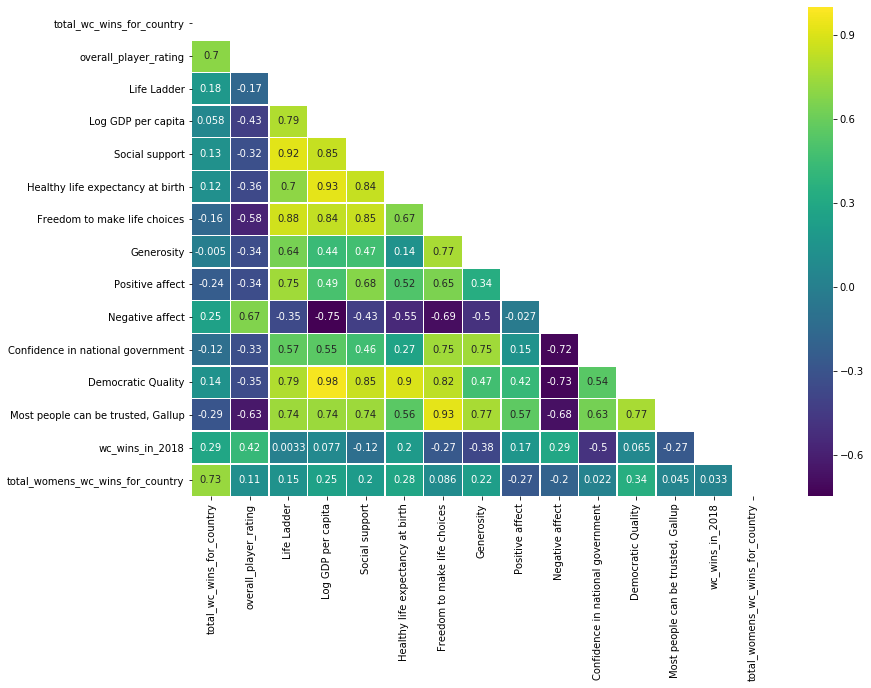

In [34]:
# If you have a lot of variables, you can use the pandas.DataFrame method corr() 
# to calculate a correlation matrix that shows the correlation coefficient for each pair of variables.
# correlated_fifa_winners_and_national_happiness
def create_correlation_heatmap(dataset, show_corr_nums):
    c_f_w_a_n_p = dataset.corr()
    mask = np.zeros_like(c_f_w_a_n_p, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(13, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(c_f_w_a_n_p, vmax=1., annot=show_corr_nums, mask=mask, linewidths=.5, cmap="viridis")
    
create_correlation_heatmap(country_happiness_player_summary_and_wc_performance_by_country, True)


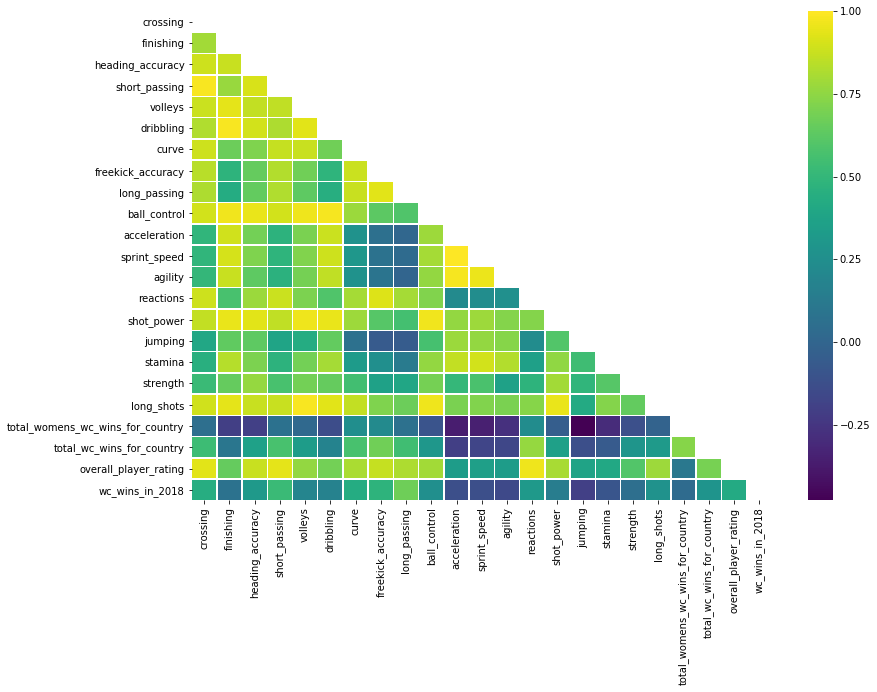

In [35]:
create_correlation_heatmap(complete_player_data_and_wc_performance_by_country, False)

In [36]:
def log_correlation_to_key_attr(dataframe, comparison_attr, comparison_set):
    my_panda = pd.DataFrame()
    for attr in comparison_set:
        x = dataframe[comparison_attr]
        y = dataframe[attr]
        z = scipy.stats.pearsonr(x.values,y.values)[0]

        a = y.corr(x)
        my_panda.at[attr, 'Pearsons'] = z
        my_panda.at[attr, 'Corr'] = a

    my_panda.sort_values(by=['Corr'], inplace=True, ascending=False)
    return my_panda

skills = [
    'overall_rating',
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'freekick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots',
]

multi_keys = [
    'total_womens_wc_wins_for_country',
    'total_wc_wins_for_country',
    'wc_wins_in_2018',
    'overall_player_rating',
]

multi_keys_b = [
    'total_womens_wc_wins_for_country',
    'total_wc_wins_for_country',
    'wc_wins_in_2018',
]

x = ' '

def log_correlation_multi(dataframe, multi_keys, comparison_set):
    my_panda = pd.DataFrame()
    for a_attr in comparison_set:
        for a_key in multi_keys:
            x = dataframe[a_key]
            y = dataframe[a_attr]
            z = scipy.stats.pearsonr(x.values,y.values)[0]

            a = y.corr(x)
            row_name = a_key + ', ' + a_attr
            my_panda.at[row_name, 'Pearsons'] = z
            my_panda.at[row_name, 'Corr'] = a

    my_panda.sort_values(by=['Corr'], inplace=True, ascending=False)
    return my_panda


In [37]:
log_correlation_multi(
    country_happiness_player_summary_and_wc_performance_by_country, 
    multi_keys, 
    key_country_attrs)


,Pearsons,Corr
"overall_player_rating, Negative affect",0.666113,0.666113
"total_womens_wc_wins_for_country, Democratic Quality",0.344066,0.344066
"wc_wins_in_2018, Negative affect",0.290408,0.290408
"total_womens_wc_wins_for_country, Healthy life expectancy at birth",0.278447,0.278447
"total_womens_wc_wins_for_country, Log GDP per capita",0.252417,0.252417
"total_wc_wins_for_country, Negative affect",0.250359,0.250359
"total_womens_wc_wins_for_country, Generosity",0.224070,0.224070
"total_womens_wc_wins_for_country, Social support",0.201961,0.201961
"wc_wins_in_2018, Healthy life expectancy at birth",0.196733,0.196733
"total_wc_wins_for_country, Life Ladder",0.180777,0.180777


In [38]:
log_correlation_multi(
    complete_player_data_and_wc_performance_by_country, 
    multi_keys_b, 
    key_player_attrs)

,Pearsons,Corr
"total_wc_wins_for_country, reactions",0.768073,0.768073
"total_wc_wins_for_country, freekick_accuracy",0.680976,0.680976
"wc_wins_in_2018, long_passing",0.675262,0.675262
"total_wc_wins_for_country, curve",0.570815,0.570815
"total_wc_wins_for_country, short_passing",0.568423,0.568423
"total_wc_wins_for_country, long_passing",0.545878,0.545878
"total_wc_wins_for_country, crossing",0.533705,0.533705
"wc_wins_in_2018, short_passing",0.522308,0.522308
"wc_wins_in_2018, freekick_accuracy",0.474787,0.474787
"wc_wins_in_2018, crossing",0.441848,0.441848


In [39]:
# group things with top ranked countries into sets to find similarities.
#fifa_top_players_skills_and_country_happiness.head()

In [40]:
def filter_for_significance(pandaset, include_only_wins, filter_name):
    dataset_list = []
    for index, row in pandaset.iterrows(): 
        dataset_row = []
        is_winning_country = False
        for col in pandaset.columns:
            if type(row[col]) is float or type(row[col]) is int:
                col_mean = pandaset[col].mean()
                if row[col] > col_mean:
                    if (col is filter_name):
                        is_winning_country = True
                    dataset_row.append(col)
        if include_only_wins:
            if is_winning_country is True:
                dataset_list.append(dataset_row)
        else:
            dataset_list.append(dataset_row)
    return dataset_list

def set_up_for_apriori(data_list):
    te = TransactionEncoder()
    te_ary = te.fit(data_list).transform(data_list)
    return pd.DataFrame(te_ary, columns=te.columns_)


In [41]:
def filter_for_consequents(data_list, consequent, antecendent_min_len, consequent_max_len, confidence_min, support_min, lift_min):
    #association_set = association_set[association_set['consequents'].astype(str).str.contains(consequent)]
    pd.set_option('display.max_colwidth', -1)
    freq_itemsets = apriori(data_list, use_colnames=True)
    association_set = association_rules(freq_itemsets, metric="lift", min_threshold=0, support_only=False)
    association_set["antecedent_len"] = association_set["antecedents"].apply(lambda x: len(x))
    association_set["consequent_len"] = association_set["consequents"].apply(lambda x: len(x))
    association_set = association_set[(association_set['antecedent_len'] >= antecendent_min_len) &
       (association_set['consequent_len'] <= consequent_max_len) &
       (association_set['consequents'].astype(str).str.contains(consequent)) &
       (association_set['confidence'] > confidence_min) &
       (association_set['support'] > support_min) &                              
       (association_set['lift'] > lift_min)]
    association_set.sort_values(by=['support', 'lift'], inplace=True, ascending=False)
    return association_set


In [42]:
a = country_happiness_player_summary_and_wc_performance_by_country
b = complete_player_data_and_wc_performance_by_country

country_happiness_player_summary_and_wc_performance_by_country - Apriori

In [43]:
significance_including_only_winners_a = set_up_for_apriori(filter_for_significance(a, True, 'total_wc_wins_for_country'))

In [44]:
# significance_no_required_attr_in_set_a = set_up_for_apriori(filter_for_significance(a, False, 'wc_wins_for_country'))

In [45]:
assoc_rules_country_happiness_on_wins = filter_for_consequents(
    significance_including_only_winners_a, 
    'total_wc_wins_for_country', 
    0, 
    1, 
    0, 
    .75,
    0)
assoc_rules_country_happiness_on_wins


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len
31,(overall_player_rating),(total_wc_wins_for_country),1.0,1.0,1.0,1.0,1.0,0.0,inf,1,1


In [46]:
assoc_rules_country_happiness_on_wins_in_2018 = filter_for_consequents(
    significance_including_only_winners_a,
    'wc_wins_in_2018',
    0,
    1,
    0,
    .5,
    0)
assoc_rules_country_happiness_on_wins_in_2018

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len
23,(Negative affect),(wc_wins_in_2018),0.666667,0.666667,0.666667,1.000000,1.5,0.222222,inf,1,1
108,"(Negative affect, overall_player_rating)",(wc_wins_in_2018),0.666667,0.666667,0.666667,1.000000,1.5,0.222222,inf,2,1
113,"(total_wc_wins_for_country, Negative affect)",(wc_wins_in_2018),0.666667,0.666667,0.666667,1.000000,1.5,0.222222,inf,2,1
220,"(total_wc_wins_for_country, Negative affect, overall_player_rating)",(wc_wins_in_2018),0.666667,0.666667,0.666667,1.000000,1.5,0.222222,inf,3,1
35,(overall_player_rating),(wc_wins_in_2018),1.000000,0.666667,0.666667,0.666667,1.0,0.000000,1.000000,1,1
39,(total_wc_wins_for_country),(wc_wins_in_2018),1.000000,0.666667,0.666667,0.666667,1.0,0.000000,1.000000,1,1
144,"(total_wc_wins_for_country, overall_player_rating)",(wc_wins_in_2018),1.000000,0.666667,0.666667,0.666667,1.0,0.000000,1.000000,2,1


In [47]:
assoc_rules_country_happiness_on_player_rating = filter_for_consequents(
    significance_including_only_winners_a,
    'overall_player_rating',
    0,
    1,
    0,
    .75,
    0)
assoc_rules_country_happiness_on_player_rating

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len
30,(total_wc_wins_for_country),(overall_player_rating),1.0,1.0,1.0,1.0,1.0,0.0,inf,1,1


complete_player_data_and_wc_performance_by_country - Apriori

In [48]:
significance_including_only_winners_b = set_up_for_apriori(filter_for_significance(b, True, 'total_wc_wins_for_country'))

In [ ]:
assoc_rules_player_data_on_wins = filter_for_consequents(
    significance_including_only_winners_b,
    'total_wc_wins_for_country',
    0,
    1,
    0,
    .65,
    0)
assoc_rules_player_data_on_wins

In [ ]:
assoc_rules_player_data_on_wins_in_2018 = filter_for_consequents(
    significance_including_only_winners_b,
    'wc_wins_in_2018',
    0,
    1,
    0,
    .4,
    0)
assoc_rules_player_data_on_wins_in_2018

In [ ]:
assoc_rules_player_data_on_player_rating = filter_for_consequents(
    significance_including_only_winners_b,
    'overall_player_rating', 
    0, 
    1, 
    0, 
    .65,
    0)
assoc_rules_player_data_on_player_rating

In [ ]:
# TODO Filter set for only correlated attributes

In [ ]:
# classification.
# Decision Trees and Bayesian Classifier
# merge 2018 WC wins into player dataset.
# look at num_wins in country happiness data
# look at num_wins in player dataset.
# run classification algorithms.
# what characteristics determine win.
# x should be data, y target.
# TODO: can use classifiers instead of float/regression

In [ ]:
def setUpDataForClassification(data_set, target_column, classified_columns, test_set_size):
    y = data_set[target_column].values.reshape(-1, 1)
    droplist = classified_columns + [target_column]
    X = data_set.drop(droplist, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=test_set_size,random_state=42,
    shuffle=True)
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    return x_train, x_test, y_train, y_test

#     y_pred = [round(value) for value in y_predicted]
#     return accuracy_score(y_test, y_pred, normalize=True)

def DTRegressionWrapper(x_train, x_test, y_train, y_test, data_set_name):
    model = DecisionTreeRegressor(max_depth=5,random_state=0)
    model.fit(x_train, y_train)
    model_score = model.score(x_train,y_train)
    print('decision tree score %.2f%%' % (model_score * 100.0))
    y_predicted = model.predict(x_test)
    exp_var = explained_variance_score(y_test, y_predicted) 
#     print('Mean squared error: %.2f'% mean_squared_error(y_test, y_predicted))
#     print('Test Variance score: %.2f' % r2_score(y_test, y_predicted))
    print("Decision Tree Explained Variance: %.2f%%" % (exp_var * 100.0))
    return (y_test, y_predicted)

def NaiveBayes(x_train, x_test, y_train, y_test):
    model = GaussianNB()
    y_predicted = model.fit(x_train, y_train).predict(x_test)
    model_score = model.score(x_train,y_train)
    print('Naive Bayes score: %.2f%%' % (model_score * 100.0))
#     print("Mislabeled of total points %d: %d"
#         % (x_train.shape[0],(y_train != y_predicted).sum()))
    accuracy = accuracy_score(y_test, y_predicted)
#     accuracy = getAccuracy(y_test, y_predicted)
    print("Naive Bayes Accuracy: ", accuracy)
    return (y_test, y_predicted)

def KNeighbors(x_train, x_test, y_train, y_test, neighbors_num):
    model = KNeighborsClassifier(n_neighbors=neighbors_num)
    y_predicted = model.fit(x_train, y_train).predict(x_test)
    model_score = model.score(x_train,y_train)
    print('KNeighbors score: %.2f%%' % (model_score * 100.0))
    # evaluate predictions
    completeness = completeness_score(y_test, y_predicted) 
#     accuracy = getAccuracy(y_test, y_predicted)
    print("KNN Completeness:", completeness)
    #TODO: graph
    return (y_test, y_predicted)

def PlotDTRegressionFit(y_test, y_predicted, algo_name):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_predicted, edgecolors=(0, 0, 0))
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Actual from Data')
    ax.set_ylabel('Predicted from Model')
    ax.set_title("Actual vs Predicted from Model: " + algo_name)
    
# def PlotKNN( y_predict):
#      # Plot the decision boundary. Multi Dimensional.
    
    
def filterByAprioriSet(data_set, correlated_set):
    selected_attrs = [col for col in data_set.columns if col in correlated_set]
    return data_set[selected_attrs]

Analysis: correlated set

In [ ]:
corr_set_countries = [
    'Social support',
    'Life Ladder',
    'Healthy life expectancy at birth',
    'Positive affect',
    'Social support',
    'total_wc_wins_for_country',
    'country',
    'overall_player_rating',
    'wc_wins_in_2018',
]

corr_set_players = [
    'long_passing',
    'overall_player_rating',
    'ball_control',
    'crossing',
    'reactions',
    'short_passing',
    'crossing',
    'total_wc_wins_for_country',
    'wc_wins_in_2018',
]

filtered_set_for_corr_country = filterByAprioriSet(
    country_happiness_player_summary_and_wc_performance_by_country, 
    corr_set_countries)

filtered_set_for_corr_players = filterByAprioriSet(
    complete_player_data_and_wc_performance_by_country, 
    corr_set_players)

In [ ]:
x_train, x_test, y_train, y_test = setUpDataForClassification(
    filtered_set_for_corr_country,
    'wc_wins_in_2018',
    ['country'],
    .33,
)
y_test_dt, y_predicted_dt = DTRegressionWrapper(
    x_train, 
    x_test, 
    y_train, 
    y_test,
    'country_happiness_player_summary_and_wc_performance_by_country',)
y_test_nb, y_predicted_nb = NaiveBayes(x_train, x_test, y_train, y_test)
y_test_kn, y_predicted_kn = KNeighbors(x_train, x_test, y_train, y_test, 1)
PlotDTRegressionFit(y_test_dt, y_predicted_dt, 'decision tree')
# PlotRegressionFit(y_test_nb, y_predicted_nb, 'naive bayes')
# PlotRegressionFit(y_test_kn, y_predicted_kn, 'k neighbors')

In [ ]:
x_train, x_test, y_train, y_test = setUpDataForClassification(
    filtered_set_for_corr_country,
    'total_wc_wins_for_country',
    ['country'],
    .33,
)
y_test_dt, y_predicted_dt = DTRegressionWrapper(
    x_train, 
    x_test, 
    y_train, 
    y_test,
    'country_happiness_player_summary_and_wc_performance_by_country',)
y_test_nb, y_predicted_nb = NaiveBayes(x_train, x_test, y_train, y_test)
y_test_kn, y_predicted_kn = KNeighbors(x_train, x_test, y_train, y_test, 1)
PlotDTRegressionFit(y_test_dt, y_predicted_dt, 'decision tree')
# PlotRegressionFit(y_test_nb, y_predicted_nb, 'naive bayes')
# PlotRegressionFit(y_test_kn, y_predicted_kn, 'k neighbors')

In [ ]:
filtered_set_for_corr_country["overall_player_rating"] = filtered_set_for_corr_country["overall_player_rating"].apply(lambda x: math.ceil(x * 100))

In [ ]:
x_train, x_test, y_train, y_test = setUpDataForClassification(
    filtered_set_for_corr_country,
    'overall_player_rating',
    ['country'],
    .33,
)
y_test_dt, y_predicted_dt = DTRegressionWrapper(
    x_train, 
    x_test, 
    y_train, 
    y_test,
    'country_happiness_player_summary_and_wc_performance_by_country',)
y_test_nb, y_predicted_nb = NaiveBayes(x_train, x_test, y_train, y_test)
y_test_kn, y_predicted_kn = KNeighbors(x_train, x_test, y_train, y_test, 1)
PlotDTRegressionFit(y_test_dt, y_predicted_dt, 'decision tree')
# PlotRegressionFit(y_test_nb, y_predicted_nb, 'naive bayes')
# PlotRegressionFit(y_test_kn, y_predicted_kn, 'k neighbors')

In [ ]:
x_train, x_test, y_train, y_test = setUpDataForClassification(
    filtered_set_for_corr_players, 
    'total_wc_wins_for_country', 
    [],
    .33,
)
y_test_dt, y_predicted_dt = DTRegressionWrapper(
    x_train, 
    x_test, 
    y_train, 
    y_test,
    'players_alltime_country_wins')
y_test_nb, y_predicted_nb = NaiveBayes(x_train, x_test, y_train, y_test)
y_test_kn, y_predicted_kn = KNeighbors(x_train, x_test, y_train, y_test, 1)
PlotDTRegressionFit(y_test_dt, y_predicted_dt, 'decision tree')
# PlotRegressionFit(y_test_nb, y_predicted_nb, 'naive bayes')
# PlotRegressionFit(y_test_kn, y_predicted_kn, 'k neighbors')

In [ ]:
x_train, x_test, y_train, y_test = setUpDataForClassification(
    filtered_set_for_corr_players, 
    'wc_wins_in_2018', 
    [],
    .33,
)
y_test_dt, y_predicted_dt = DTRegressionWrapper(
    x_train, 
    x_test, 
    y_train, 
    y_test,
    'filtered_set_for_corr_players')
y_test_nb, y_predicted_nb = NaiveBayes(x_train, x_test, y_train, y_test)
y_test_kn, y_predicted_kn = KNeighbors(x_train, x_test, y_train, y_test, 1)
PlotDTRegressionFit(y_test_dt, y_predicted_dt, 'decision tree')
# PlotRegressionFit(y_test_nb, y_predicted_nb, 'naive bayes')
# PlotRegressionFit(y_test_kn, y_predicted_kn, 'k neighbors')

In [ ]:
# check to see if algorithms make sense, since this should be 100% easy to predict, 
# as player rating and skill levels are always correlated by definition of
# what makes a great player
filtered_set_for_corr_players["overall_player_rating"] = filtered_set_for_corr_players["overall_player_rating"].apply(lambda x: math.ceil(x * 100))
x_train, x_test, y_train, y_test = setUpDataForClassification(
    filtered_set_for_corr_players, 
    'overall_player_rating', 
    [],
    .33,
)
y_test_dt, y_predicted_dt = DTRegressionWrapper(
    x_train, 
    x_test, 
    y_train, 
    y_test,
    'filtered_set_for_corr_players')
y_test_nb, y_predicted_nb = NaiveBayes(x_train, x_test, y_train, y_test)
y_test_kn, y_predicted_kn = KNeighbors(x_train, x_test, y_train, y_test, 1)
PlotDTRegressionFit(y_test_dt, y_predicted_dt, 'decision tree')
# PlotRegressionFit(y_test_nb, y_predicted_nb, 'naive bayes')
# PlotRegressionFit(y_test_kn, y_predicted_kn, 'k neighbors')

In [ ]:
# toDo
# determine score/ write out score better and improve graphs